In [17]:
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from scipy.stats import gaussian_kde

#library to create the pipeline
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn import set_config
from my_transformers import NoTransformer

#to save and load the pipeline and model fitted in a pickle (.pkl) file
import pickle
#import dill as pickle
#import dill

#import geocoder
#from geopy.geocoders import GoogleV3

<title>California housing from the 90's</title>

In [18]:
df_original = pd.read_csv('housing.csv')

In [19]:
df_original.describe()

longitude      latitude  housing_median_age   total_rooms  \
count  20640.000000  20640.000000        20640.000000  20640.000000   
mean    -119.569704     35.631861           28.639486   2635.763081   
std        2.003532      2.135952           12.585558   2181.615252   
min     -124.350000     32.540000            1.000000      2.000000   
25%     -121.800000     33.930000           18.000000   1447.750000   
50%     -118.490000     34.260000           29.000000   2127.000000   
75%     -118.010000     37.710000           37.000000   3148.000000   
max     -114.310000     41.950000           52.000000  39320.000000   

       total_bedrooms    population    households  median_income  \
count    20433.000000  20640.000000  20640.000000   20640.000000   
mean       537.870553   1425.476744    499.539680       3.870671   
std        421.385070   1132.462122    382.329753       1.899822   
min          1.000000      3.000000      1.000000       0.499900   
25%        296.000000    787.000000    280.000000       2.563400   
50%        435.000000   1166.000000    409.000000       3.534800   
75%        647.000000   1725.000000    605.000000       4.743250   
max       6445.000000  35682.000000   6082.000000      15.000100   

       median_house_value  
count        20640.000000  
mean        206855.816909  
std         115395.615874  
min          14999.000000  
25%         119600.000000  
50%         179700.000000  
75%         264725.000000  
max         500001.000000

In [20]:
df_original.shape

(20640, 10)

<h1>Choix du dataset et brief descriptif:</h1>

Le dataset choisi sur le site Kaggle ("California Housing Prices") porte sur des données immobilières collectées dans les années 90 et couvre l'ensemble de l'état de Californie.

Le dataset reporte:
<ul>
<li>la géolocalisation du district (latitude & longitude)</li>
<li>housing_median_age = age médian des ménages</li>
<li>total_rooms = nombre total de pièces dans le district</li>
<li>total_bedrooms = nombre total de chambres</li>
<li>population</li>
<li>households = nombre de ménages</li>
<li>médian_income = revenue médian</li>
<li>médian_house_value = prix médian des maisons</li>
<li>ocean_proximity = la proximity du district avec l'océan avec 5 catégories ('<1H OCEAN', 'INLAND', 'NEAR OCEAN', 'NEAR BAY', 'ISLAND')</li></ul>
Le dataset possède 10 colonnes et 20640 lignes

<h2>Objectifs principaux:</h2>
<ul>    
<li>Réaliser un modèle permettant de prédire le prix médian des maisons d'un district</li>
<li>Réaliser une API utilisant ce modèle et renvoyant la prédiction</li>
</ul>
<h2>Objectifs annexes (pour le fun):</h2>
<ul>
<li>Créer une feature catégorielle de type code postal à partir des coordonnées de géolocalisation</li>
<li>Présenter des données sur une carte (géovisualisation)</li>
</ul>
C'est parti!!!

<h1>Data cleaning and feature engineering</h1>

<h2>Création d'une feature catégorielle de type code postal/zip code à partir des coordonnées de géolocalisation</h2>

Le but est ici de recupérer via l'API de géolocalisation de google map les addresses correspondant aux coordonnées pour chaque points du dataset en itérant sur le dataframe. Un compte a été créer à cet effet afin de récupérer une api_key. Google autorise 40000 requettes par mois sans frais pour cette API.
Les données JSON ont été stockées dans un dictionnaire, la clés correspondant à l'index du dataset. Le dictionnaire a ensuite été converti en dataframe et la colonne d'intéret ajouter au dataset, puis sauvagardé au format .csv



In [21]:
#from geopy.geocoders import GoogleV3

#google_key = "my_api_key"
#geolocator = GoogleV3(api_key = google_key)

#dict_geoloc = {}

#for i in range(0, len(X.index)):
#    lat = X['latitude'][i]
#    long = X['longitude'][i]
#    coordinates = f"{lat}, {long}"
#    locations = geolocator.reverse(coordinates)
#    address = str(locations)
#    dict_geoloc[i] = address  
#dict_geoloc_pd = pd.DataFrame.from_dict(dict_geoloc, orient = 'index')
#df['addresses'] = dict_geoloc_pd[0]
#df.to_csv('housing_geoloc.csv')

In [22]:
#Reload du dataset with the 'addresses' colonne
df = pd.read_csv('housing_geoloc.csv')
df = pd.DataFrame(df)
df = df.drop(columns = ['Unnamed: 0'])

In [23]:
df.head(3)

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
0    -122.23     37.88                41.0        880.0           129.0   
1    -122.22     37.86                21.0       7099.0          1106.0   
2    -122.24     37.85                52.0       1467.0           190.0   

   population  households  median_income  median_house_value ocean_proximity  \
0       322.0       126.0         8.3252            452600.0        NEAR BAY   
1      2401.0      1138.0         8.3014            358500.0        NEAR BAY   
2       496.0       177.0         7.2574            352100.0        NEAR BAY   

                                         addresses  
0  3126 Grizzly Peak Blvd, Berkeley, CA 94705, USA  
1           2005 Tunnel Rd, Oakland, CA 94611, USA  
2                         RQX5+XX Oakland, CA, USA

<h2>Visualisation des données quantitatives (hist)</h2>

<ul><li>On note que la distribution des données est de manière générale biaisée, ou ne suis pas de lois normale</li>

<li>On note aussi que certaines variables possèdent des distributions abérrantes de variables dans leurs limites supérieurs. Par exemple, median_hous_value plafonne à 500 000 dollars, valeur pour laquelle un très grand nombre de ligne (5% environ) sont représentées. Les valeurs supérieurs ont donc été tronquées à 500 000 dollars, et ces lignes ne seront donc pas continues. Le même type d'observation est faites pour les variables median_income et housing_mean_age.</li>

<li>Concernant la variable catégorielle ocean_proximity, la classe ISLAND n'est représenté que 5 fois sur 20000... les lignes correspondantes devront être supprimées ou requalifiées si utilisées ultérieurement au sein du modèle</li></ul>



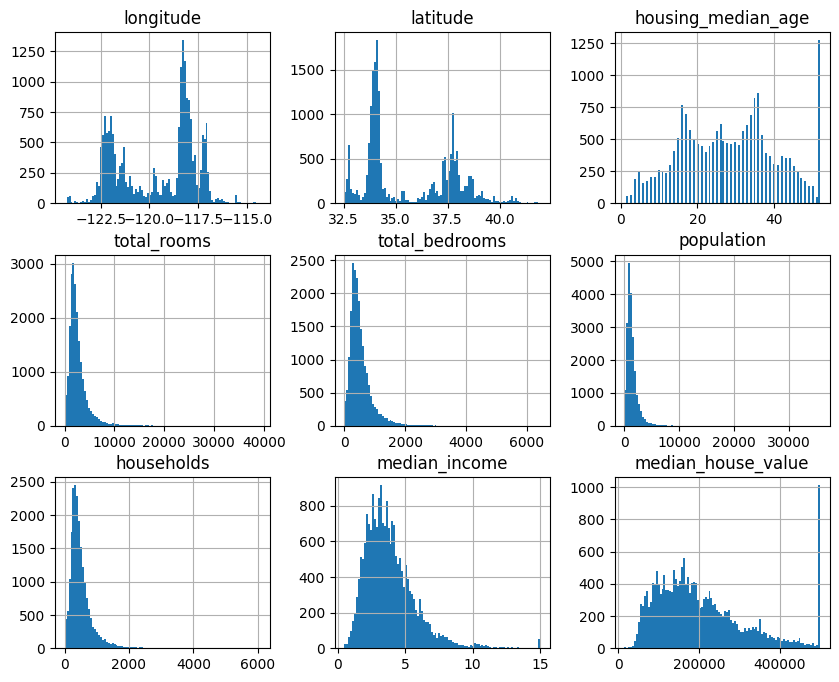

In [24]:
df.hist(bins = 100, figsize = (10,8))
plt.show()

Dans l'ensemble, ni les variables dépendentes et indépendent ne suivent une distribution normale, ce qui justifie l'utilisation d'un modèle non-paramétrique. L'utilisation d'un modèle paramétrique (regression linéaire, Ridge/Lasso (modèles linéaires incluant avec régularisation)) nécessiterait une transformation préalable des features afin d'éventuellement atteint les hypothèses dans lesquels peuvent être appliqué le modèle linéaire (linearité, indépendence des variables indépendantes, homoscédasticité des résidues, normalité, absence de collinéarité des variables indépendantes)

# Nettoyage du dataset

Le code suivant à pour objectif d'extraire le ZIP code de l'adresse.

La démarche et la suivante:
<ul><li>La string de l'adresse est transformée en liste (.split())</li>
<li>Les longueurs des listes sont évaluées</li>
<li>Les lignes pour lesquelles la longueur est inférieurs à 2 sont supprimées, car elles ne contiennent pas de ZIP code</li>
<li>L'avant-dernier élément de chaque listes (str) est copier dans une nouvelle colonne >>> str de type 'CA 92506'</li>
<li>La ville est aussi récupérer >>> antépénultième élément de chaque liste</li>
<li>Le 'CA' est supprimé de la strip afin de récupérer uniquement le ZIP code</li>
<li>Les lignes dans lesquelles le zip code est vide sont supprimées</li>
<li>Uniquement les cinqs derriers éléments de chaque ZIP code sont sélectionnées dans le doute</li>
<li>Les lignes n'ayant pas de ZIP code commencant par 9 sont supprimées</li>
<li>Des ZIP codes simplifiés sont créés en ne retenant que les deux ou trois premiers numéro du code afin de diminuer le nombre de classes de ZIP</li>
</ul>

In [25]:
df.shape

(20640, 11)

In [26]:
df['list_adresses'] = df['addresses'].apply(lambda x: x.split(','))
df['len_list_adresses'] = df['list_adresses'].apply(lambda x: len(x))
df = df[df['len_list_adresses'] > 2]
df['zip_code'] = df['list_adresses'].apply(lambda x: x[-2].replace('CA', '').strip())
df['city'] = df['list_adresses'].apply(lambda x: x[-3])
df = df[df['zip_code'] != '']
df['zip_code'] = df['zip_code'].apply(lambda x: x[-5:])
df['zip_code'] = df['zip_code'].apply(lambda x: x if x[0] == '9' else 'NA')
df = df[df['zip_code'] != 'NA']
df['zip_simplified'] = df['zip_code'].apply(lambda x: x[0:-2])
df['zip_simplified2'] = df['zip_code'].apply(lambda x: x[0:-3])


a = df['zip_simplified'].value_counts().reset_index()
a = pd.DataFrame(a)
dict ={}
for i in range(len(a['index'])):
    dict[a['index'].iloc[i]] = a['zip_simplified'].iloc[i]
df['zip_simp_numb'] = df['zip_simplified'].apply(lambda x: dict[x])
#df = df[df['zip_simp_numb'] > 50]

In [27]:
df.head(3)

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
0    -122.23     37.88                41.0        880.0           129.0   
1    -122.22     37.86                21.0       7099.0          1106.0   
3    -122.25     37.85                52.0       1274.0           235.0   

   population  households  median_income  median_house_value ocean_proximity  \
0       322.0       126.0         8.3252            452600.0        NEAR BAY   
1      2401.0      1138.0         8.3014            358500.0        NEAR BAY   
3       558.0       219.0         5.6431            341300.0        NEAR BAY   

                                         addresses  \
0  3126 Grizzly Peak Blvd, Berkeley, CA 94705, USA   
1           2005 Tunnel Rd, Oakland, CA 94611, USA   
3           6365 Florio St, Oakland, CA 94618, USA   

                                       list_adresses  len_list_adresses  \
0  [3126 Grizzly Peak Blvd,  Berkeley,  CA 94705,...                  4   
1        [2005 Tunnel Rd,  Oakland,  CA 94611,  USA]                  4   
3        [6365 Florio St,  Oakland,  CA 94618,  USA]                  4   

  zip_code       city zip_simplified zip_simplified2  zip_simp_numb  
0    94705   Berkeley            947              94            127  
1    94611    Oakland            946              94            375  
3    94618    Oakland            946              94            375

In [28]:
print(f'{(round((20640 - df.shape[0])/20640, 4))*100}% du dataset a été supprimé')

11.86% du dataset a été supprimé


<ul>
<li>2448 lignes sont supprimés car elle ne contiennent pas de données ZIP code valides pour l'état de Californie (environ 12% des données)</li>
<li>les données supérieurs tronquées sont supprimés ainsi que la classe ISLAND</li>
<li>une variable pop_per_rooms est créer afin de refléter la demande immobilière</li>
<li>une valeur extrême est supprimée, 1450 personnes par pièces!</li>
<li>les colonnnes inutiles sont supprimées</li>
</ul>

In [29]:
df = df[df['median_house_value'] < 499000]
df = df[df['housing_median_age'] < 52]
df = df[df['median_income'] < 15.0001]
df['pop_per_rooms'] = df['population']/df['total_rooms']
df = df[df['pop_per_rooms'] < 50]
df = df[df['ocean_proximity'] != 'ISLAND']
df = df.drop(columns = ['addresses', 'list_adresses', 'len_list_adresses', 'zip_code', 'city', 'zip_simp_numb'])

In [30]:
print(f'{(round((20640 - df.shape[0])/20640, 4))*100}% du dataset a été supprimé')

21.09% du dataset a été supprimé


<ul>
<li>nous avons perdu environ 21% des lignes du dataset à ce stade</li>
    <li>mais le dataset est maintenant "propre"</li>
</ul>

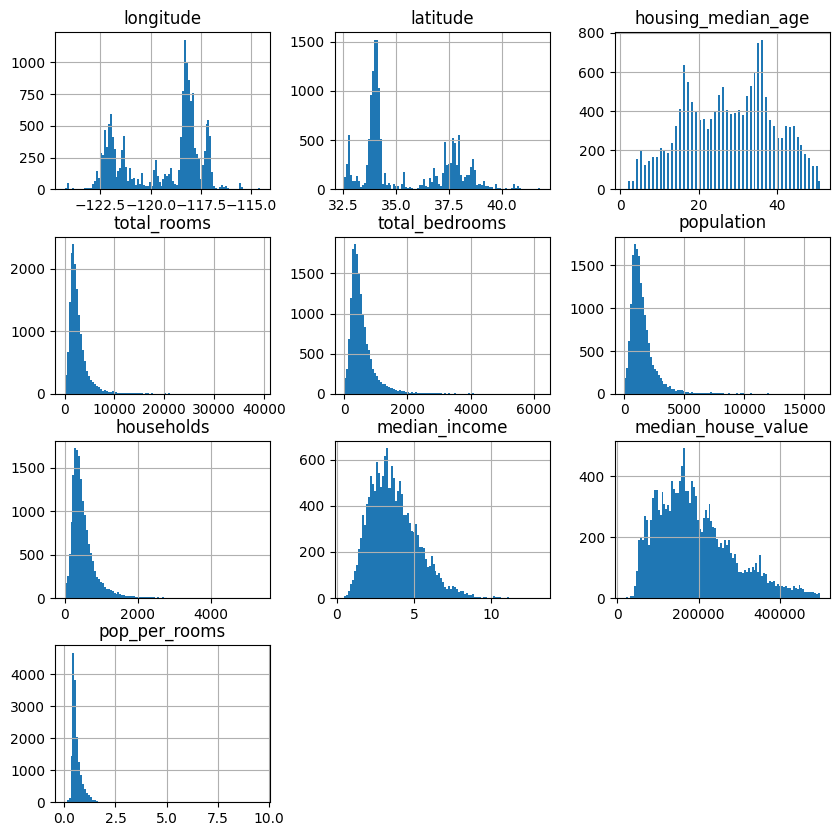

In [31]:
df.hist(bins = 100, figsize = (10,10))
plt.show()

Nous visualisons maintenant les données sur la carte de Californie avec Geopandas!

In [32]:
#we import the map of the california states
zipfile = 'zip:///home/jerome/code/J-Pouzoulet/IA3/housing/cb_2018_us_state_20m.zip'

states = gpd.read_file(zipfile)
#states = gpd.read_file(https://www2.census.gov/geo/tiger/GENZ2018/shp/cb_2018_us_state_20m.zip)

Nous créons une carte sur laquel nous représentons (i) la population (cercle dont la taille est fonction de la population) et (ii) le prix médian de l'immobilier (par un code couleur)

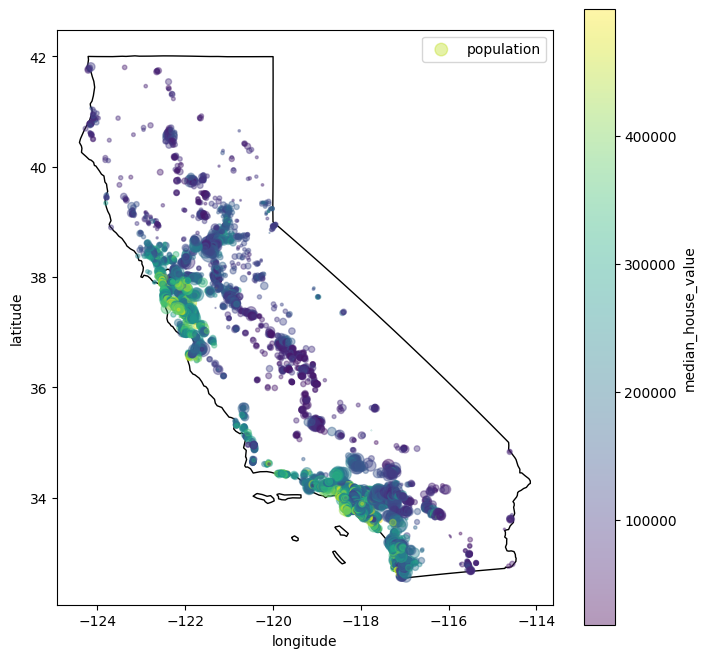

In [33]:
gdf = gpd.GeoDataFrame(
    df, geometry=gpd.points_from_xy(df.longitude, df.latitude))

zipfile = 'zip:///home/jerome/code/J-Pouzoulet/IA3/housing/cb_2018_us_state_20m.zip'
states = gpd.read_file(zipfile)

fig, ax = plt.subplots(figsize = (8,8))

ax.set_aspect('equal')

states[states['NAME'] == 'California'].plot(ax=ax, color='white', edgecolor='black')

gdf.plot(ax=ax, kind="scatter", x="longitude", y="latitude",
    s=df['population']/100, label="population",
    c="median_house_value", cmap=plt.get_cmap("viridis"),
    colorbar=True, alpha=0.4)

plt.show()

<h1>Choix des paramètres du modèle</h1>
<ul>
<li>Seaborn.pairplot() s'impose afin de visualiser la meilleur feature pour expliquer le median_house_value</li>
</ul>

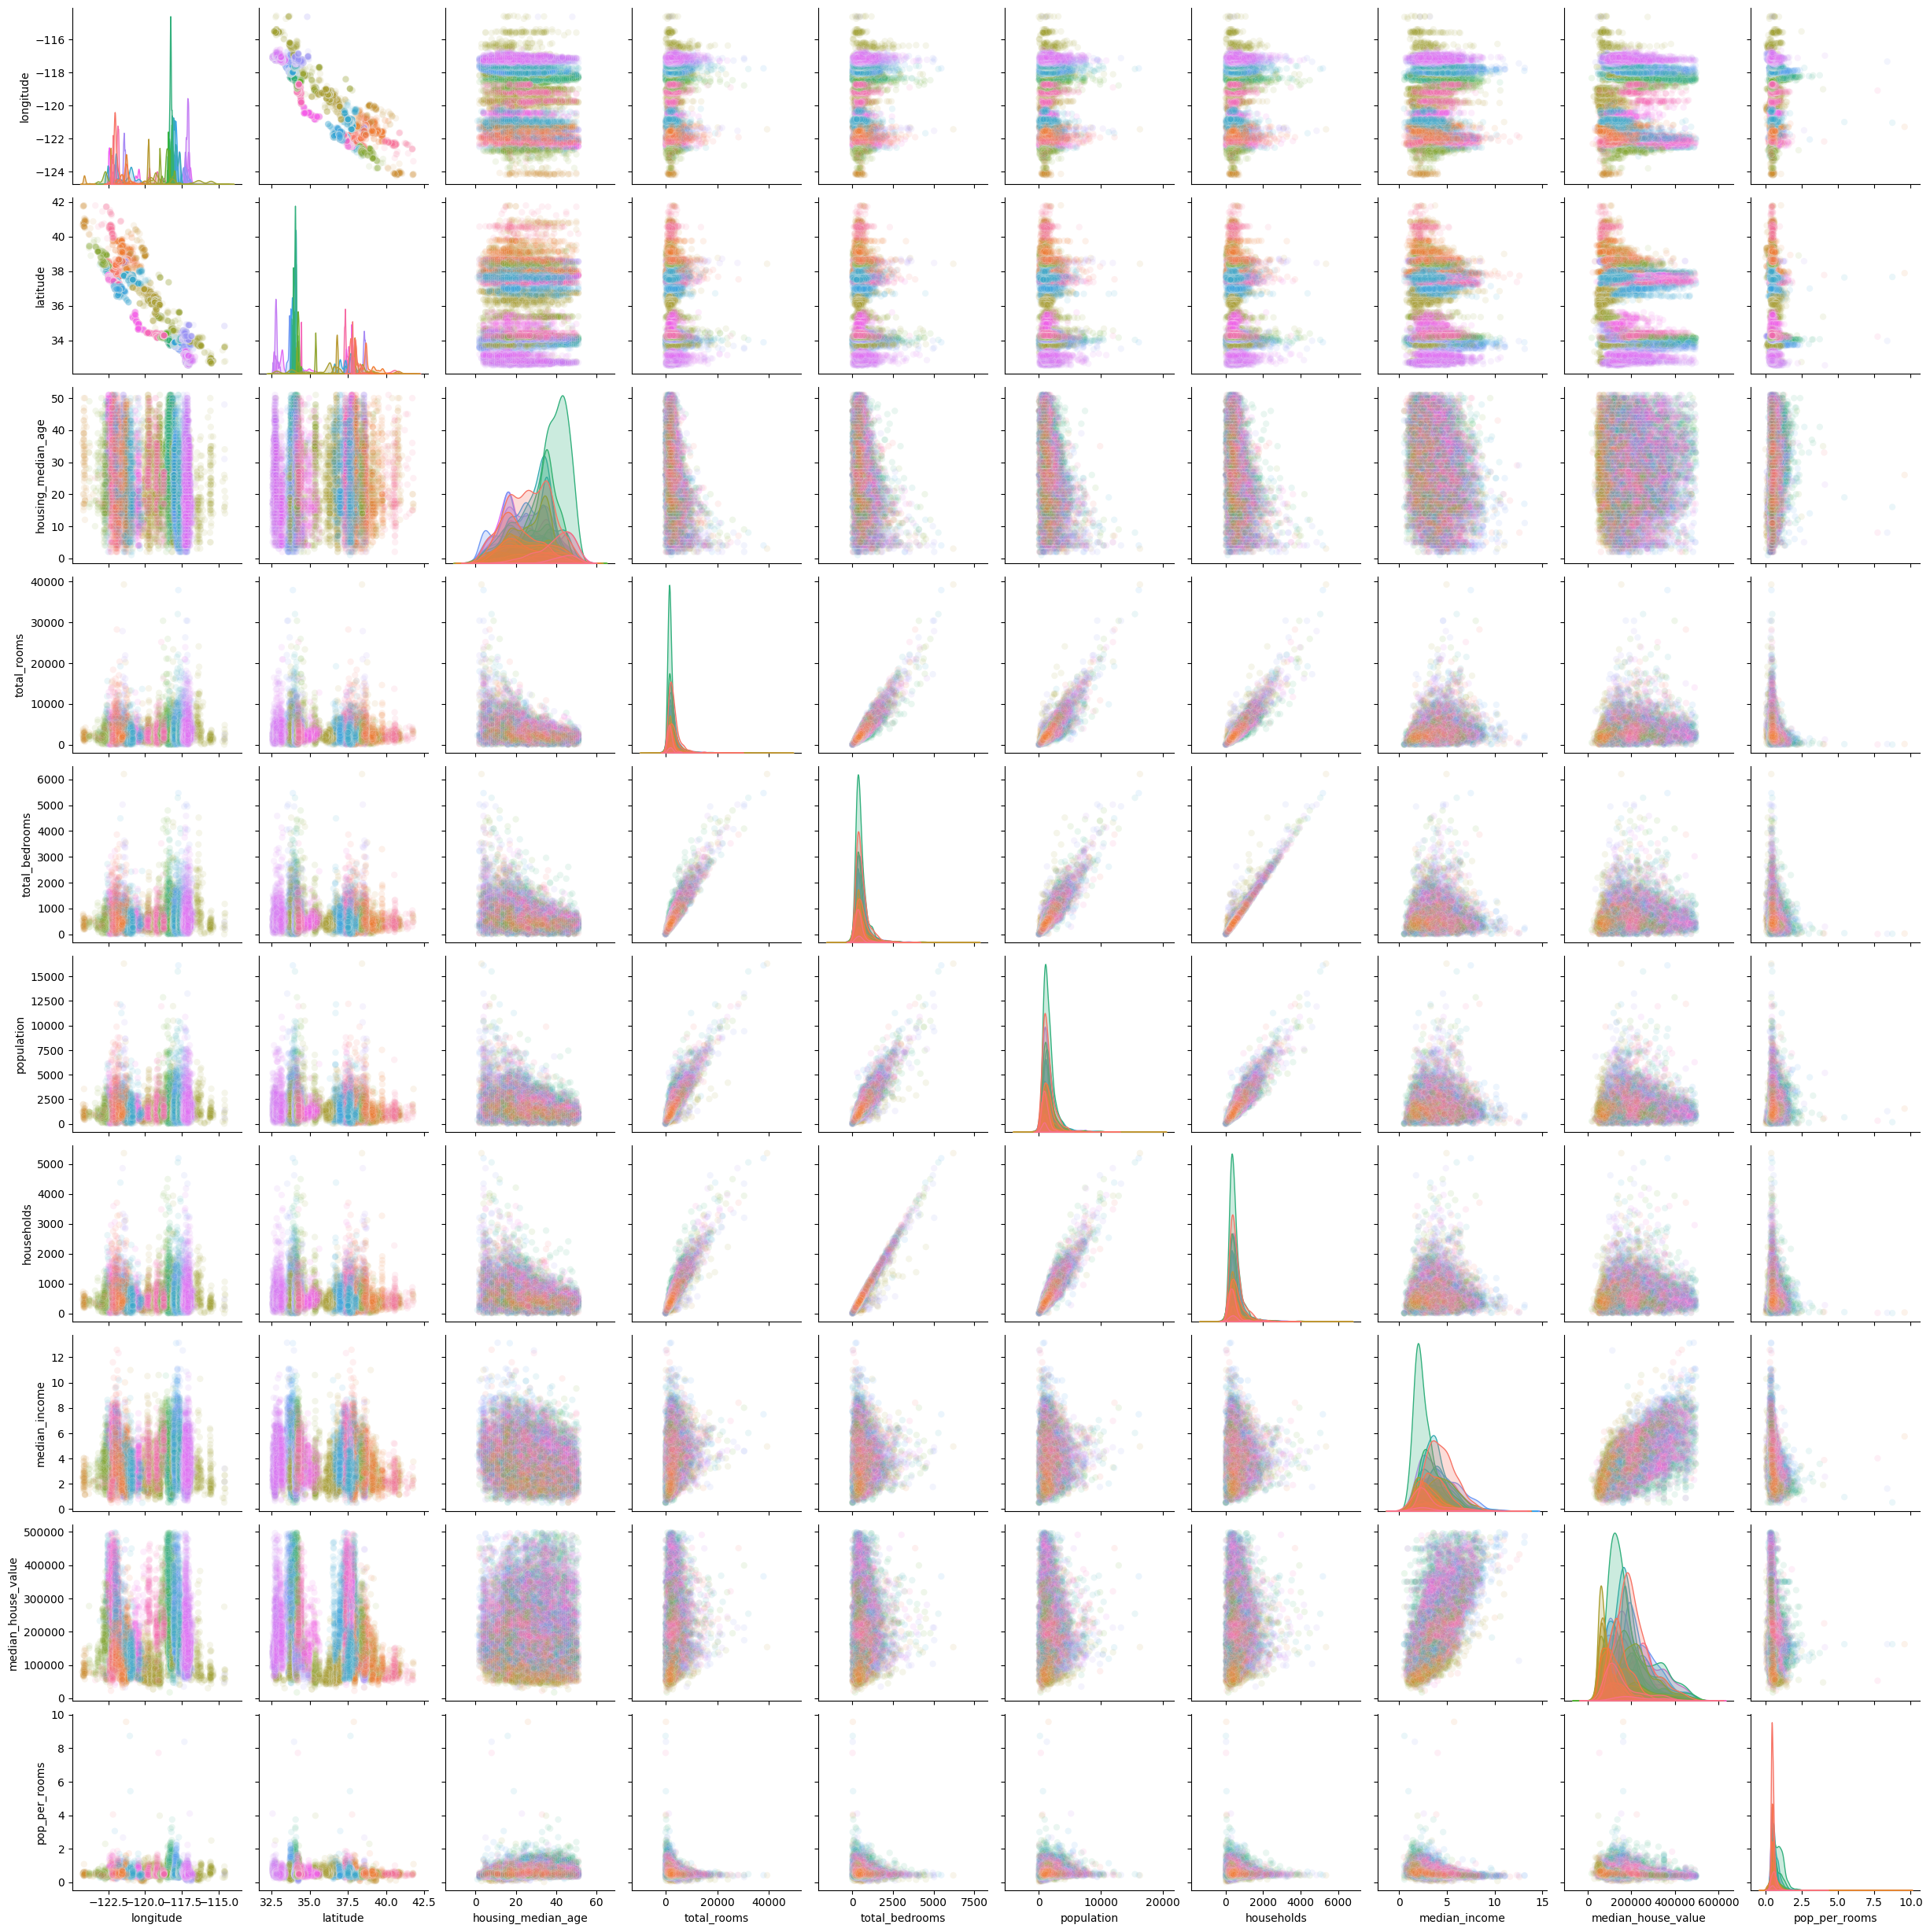

In [34]:
g = sns.pairplot(df, hue = 'zip_simplified', plot_kws={'alpha':0.1})
g._legend.remove()
plt.show()

<ul>
<li>La variable 'median_income' semble être corrélée avec la variable cible 'median_house value'</li>
<li>D'autres variables sont fortement corrélées entre elles (e.g., 'total_rooms', 'total_bedrooms', 'populations', 'households')</li>
<li>Nous pourrons réduire le nombre de dimensions et créer des variables non-corrélés par l'utilisation d'une analyse en composante principale</li>
</ul>

# Création du Pipeline</h1>


Les lignes suivant génèrent les datasets train et test. 

Nous pouvons d'abord nous séparer de la colonne zipcode, qui nous a néanmoins permis de vérifier que l'ensemble des données appartient bien à l'état de Californie, et de deux autres features  

In [35]:
df.columns

Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'median_house_value', 'ocean_proximity', 'zip_simplified',
       'zip_simplified2', 'pop_per_rooms', 'geometry'],
      dtype='object')

In [36]:
#drop the comlumns zip_simplified2 and zip_simplified
df = df.drop(columns = ['zip_simplified2', 'zip_simplified', 'ocean_proximity', 'geometry'])

In [37]:
X = df.drop(columns=['median_house_value'])
y = df['median_house_value']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 52)

In [38]:
X_train.head(3)

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
3757     -118.38     34.19                30.0        977.0           264.0   
13962    -116.88     34.25                11.0       1089.0           198.0   
12039    -117.46     33.90                10.0       9738.0          2130.0   

       population  households  median_income  pop_per_rooms  
3757        736.0       258.0         1.9866       0.753327  
13962       230.0        90.0         4.9643       0.211203  
12039      4936.0      1840.0         3.3187       0.506880

Le pipeline ci-dessous peut paraitre minimaliste néanmoins il comporte ici tout ce qui sera nécessaire

In [39]:
X.columns

Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'pop_per_rooms'],
      dtype='object')

In [40]:
from sklearn.decomposition import PCA
from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler
#we want the PCA to explain at least 95% of the variance

pca = PCA(n_components=0.95)
xgbr = XGBRegressor()

num_pipeline = Pipeline([('simpleimputer', SimpleImputer()),
                     ('sdandardscaler', StandardScaler()),
                     ('pca', PCA(n_components=0.95)),])

preprocessor = ColumnTransformer([('num_transform', num_pipeline, ['housing_median_age', 'total_rooms',
                                    'total_bedrooms', 'population', 'households', 'median_income',
                                    'pop_per_rooms']),
                                ('NoTransformer', NoTransformer(), ['longitude', 'latitude']),
                                ])

workflow = make_pipeline(preprocessor, xgbr)

set_config(display="diagram")

workflow

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num_transform',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('sdandardscaler',
                                                                   StandardScaler()),
                                                                  ('pca',
                                                                   PCA(n_components=0.95))]),
                                                  ['housing_median_age',
                                                   'total_rooms',
                                                   'total_bedrooms',
                                                   'population', 'households',
                                                   'median_income',
                                                   'pop_per_rooms']),
                                                 ('NoTransformer',
                                                  NoTransformer()...
                              gamma=None, gpu_id=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=None,
                              max_bin=None, max_cat_to_onehot=None,
                              max_delta_step=None, max_depth=None,
                              max_leaves=None, min_child_weight=None,
                              missing=nan, monotone_constraints=None,
                              n_estimators=100, n_jobs=None,
                              num_parallel_tree=None, predictor=None,
                              random_state=None, reg_alpha=None,
                              reg_lambda=None, ...))])

Regardons les clés des hyperparamètres de l'objet worflow

In [41]:
workflow.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'columntransformer', 'xgbregressor', 'columntransformer__n_jobs', 'columntransformer__remainder', 'columntransformer__sparse_threshold', 'columntransformer__transformer_weights', 'columntransformer__transformers', 'columntransformer__verbose', 'columntransformer__verbose_feature_names_out', 'columntransformer__num_transform', 'columntransformer__NoTransformer', 'columntransformer__num_transform__memory', 'columntransformer__num_transform__steps', 'columntransformer__num_transform__verbose', 'columntransformer__num_transform__simpleimputer', 'columntransformer__num_transform__sdandardscaler', 'columntransformer__num_transform__pca', 'columntransformer__num_transform__simpleimputer__add_indicator', 'columntransformer__num_transform__simpleimputer__copy', 'columntransformer__num_transform__simpleimputer__fill_value', 'columntransformer__num_transform__simpleimputer__keep_empty_features', 'columntransformer__num_transform__simpleimputer__missing_val

Cherchons les meileurs paramètres du modèle en utilisant GridSearchCV (recherche automatisée des meilleurs hyperparamètres du modèle sur une validation croisée)
Nous fesons une gridsearch sur les hyperparamètres critiques de XGBRegressor (voir param_grid) 

In [42]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'xgbregressor__n_estimators': [50, 100, 200, 300],
    'xgbregressor__max_depth': [3, 4, 5, 8, 10],
    'xgbregressor__learning_rate': [0.1, 0.01, 0.05]
}

grid_search = GridSearchCV(workflow, param_grid, cv = 5, verbose = 1, n_jobs = -1)
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 60 candidates, totalling 300 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('num_transform',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer()),
                                                                                         ('sdandardscaler',
                                                                                          StandardScaler()),
                                                                                         ('pca',
                                                                                          PCA(n_components=0.95))]),
                                                                         ['housing_median_age',
                                                                          'total_rooms',
                                                                          'total_bedrooms',
                                                                          'population',
                                                                          'households',
                                                                          'median_income',
                                                                          'pop_per_rooms']),
                                                                        ('No...
                                                     max_leaves=None,
                                                     min_child_weight=None,
                                                     missing=nan,
                                                     monotone_constraints=None,
                                                     n_estimators=100,
                                                     n_jobs=None,
                                                     num_parallel_tree=None,
                                                     predictor=None,
                                                     random_state=None,
                                                     reg_alpha=None,
                                                     reg_lambda=None, ...))]),
             n_jobs=-1,
             param_grid={'xgbregressor__learning_rate': [0.1, 0.01, 0.05],
                         'xgbregressor__max_depth': [3, 4, 5, 8, 10],
                         'xgbregressor__n_estimators': [50, 100, 200, 300]},
             verbose=1)

Regardons quelles sont les meilleurs paramètres du modèles

In [43]:
#check the best parameters
grid_search.best_params_

{'xgbregressor__learning_rate': 0.1,
 'xgbregressor__max_depth': 5,
 'xgbregressor__n_estimators': 300}

Regardons la variabilité de la valeur médiane des maisons expliquée par le modèle sur le jeu de données d'entrainement

In [44]:
#check the score on the train set
grid_search.best_score_

0.8146210440342958

Nous expliquons 81% de la variance, pas mal

Vérifions si le modèle généralise correctement sur le jeu de données test

In [45]:
#check the score on the test set
grid_search.score(X_test, y_test)

0.8128982359199539

La variance expliquée par le modèle sur le jeux test est pratiquement similaire à celle observée sur le jeux d'entrainement, nous pouvons donc conclure que le modèle généralise bien sur de nouvelles données 

### Regardons l'effet de la taille du jeux d'entrainement sur les performances du modèle

In [46]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(
    estimator=grid_search.best_estimator_,
    X=X_train,
    y=y_train,
    cv=5,
    scoring="r2",
    train_sizes = [50,100,200,500,1000,2000,4000,6000,8000,9120])

train_mean = train_scores.mean(axis=1)
test_mean = test_scores.mean(axis=1)

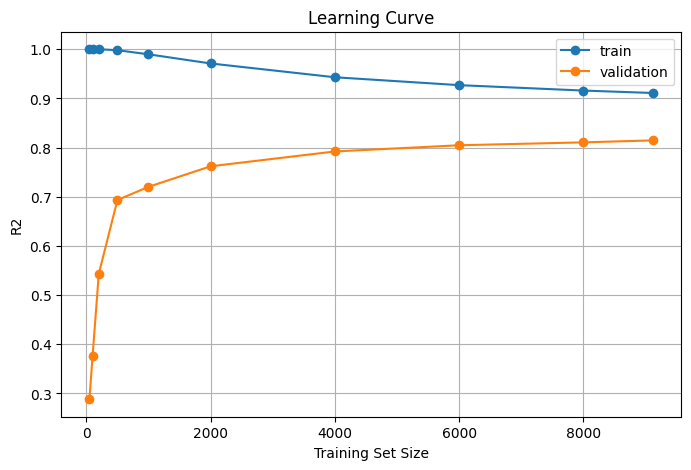

In [47]:
plt.subplots(figsize=(8,5))
plt.plot(train_sizes, train_mean, label="train", marker='o')
plt.plot(train_sizes, test_mean, label="validation", marker='o')

plt.title("Learning Curve")
plt.xlabel("Training Set Size")
plt.ylabel("R2")
plt.legend(loc="best")
plt.grid(True)
plt.show()

Nous pouvons conclure que la performance du modèle (R2) n'a toujours pas atteint un plateau lorsque l'ensemble des données d'entrainement sont utilisés. Un dataset plus large permettrait donc d'améliorer la précision du modèle. 

Traçons maintenant la "observed vs predicted curve" afin de déterminer la qualité des prédictions sur le gradient de valeurs cibles observés 

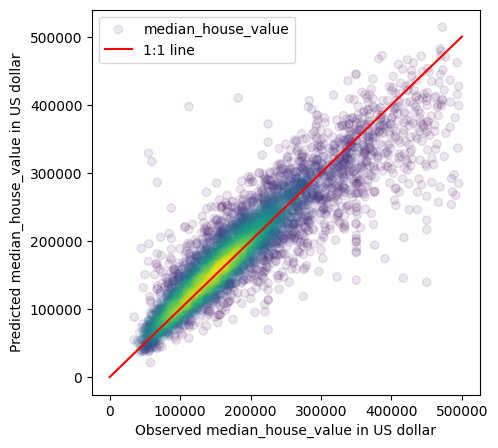

In [48]:
pred = grid_search.predict(X_test)

xy = np.vstack([y_test,pred])
z = gaussian_kde(xy)(xy)

plt.figure(figsize = (5,5))
plt.scatter(y_test, pred, alpha = 0.1, c = z, label = 'median_house_value')
plt.plot([0,500000],[0,500000], c ='r', label = '1:1 line')
plt.xlabel('Observed median_house_value in US dollar')
plt.ylabel('Predicted median_house_value in US dollar')
plt.legend()
plt.show()

On peut remarquer que les valeurs sont ramassées autour de la ligne 1:1 (ligne théorique sur laquelle les valeurs prédites sont égales aux valeurs observées) sur toute la magnitude des valeurs cibles. Néanmoins les prédictions sous estime souvent le prix médian pour les valeurs supérieures à 300 000 dollars (points se situant alors sous la courbe 1:1). Des précautions seraient à prendre en compte pour ces valeurs.   

Regardons la distribution des résidues

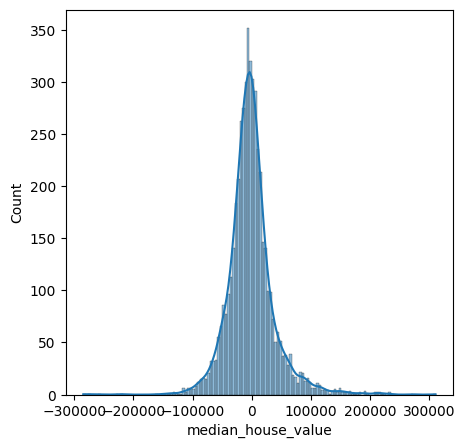

In [50]:
#calculate the residuals and plot them
res = y_test - pred
plt.figure(figsize = (5,5))
sns.histplot(res, kde=True)
plt.show()

Les résidues sont distribués de manière normale et centrés sur zéro

Nous pouvons maintenant entrainer le modèle sur l'ensemble des données en utilisant les meilleurs hyperparamètres et une validation croisée

In [51]:
param_grid = {
    'n_estimators': [300],
    'max_depth': [5],
    'learning_rate': [0.1]
}

grid_search = GridSearchCV(xgbr, param_grid, cv = 5, verbose = 1, n_jobs = -1)
grid_search.fit(X, y)
grid_search.best_estimator_

Fitting 5 folds for each of 1 candidates, totalling 5 fits


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.1, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=5, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=300, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

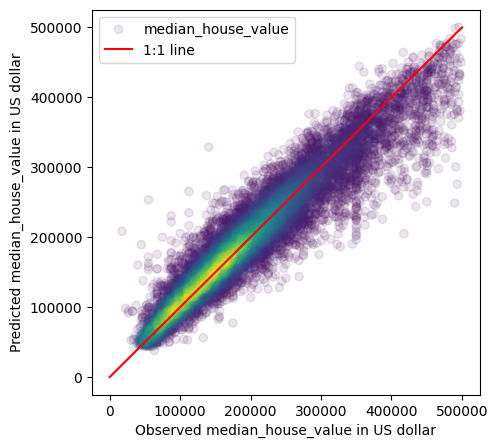

In [52]:
pred = grid_search.predict(X)

xy = np.vstack([y,pred])
z = gaussian_kde(xy)(xy)

plt.figure(figsize = (5,5))
plt.scatter(y, pred, alpha = 0.1, c = z, label = 'median_house_value')
plt.plot([0,500000],[0,500000], c ='r', label = '1:1 line')
plt.xlabel('Observed median_house_value in US dollar')
plt.ylabel('Predicted median_house_value in US dollar')
plt.legend()
plt.show()

<h2>Sauvegarde du workflow entrainé avec Pickle</h2>

In [53]:
pickle.dump(workflow, open('housing_trained.pkl', 'wb'))

Le workflow est maintenant sauvegardé dans un fichier .pkl est peut donc être exporté/importé facilement pour son utilisation dans une REST-API (voir housing_API.py)  